# **Imports**

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import os
import joblib

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data_dir = os.getcwd() + "/data"
model_file_name = "new_df.joblib"
path = os.path.join(data_dir, model_file_name)
new_df = joblib.load(path)

# **Simulations**

## **Investing $50 on every positive prediction**


- create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"
- fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [3]:
# current prediction
pred = 'pred6_clf_best'

In [4]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close.count()
     

np.int64(106994)

In [5]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

965

In [7]:
new_df.keys().to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividends',
 'Stock Splits',
 'ticker_type',
 'Ticker',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_future_30d',
 'SMA10',
 'SMA20',
 'growing_moving_average',
 'high_minus_low_relative',
 'volatility',
 'is_positive_growth_30d_future',
 'Capital Gains',
 'index_x',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'index_y',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_inphase',
 'ht_phasor_quadrature',
 'ht_sine_sine',
 'ht_sine_lead

In [8]:
# growth indicators (but not future growth)
GROWTH = [g for g in new_df.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_^GSPC_1d',
 'growth_^GSPC_3d',
 'growth_^GSPC_7d',
 'growth_^GSPC_30d',
 'growth_^GSPC_90d',
 'growth_^GSPC_365d',
 'growth_^DJI_1d',
 'growth_^DJI_3d',
 'growth_^DJI_7d',
 'growth_^DJI_30d',
 'growth_^DJI_90d',
 'growth_^DJI_365d',
 'growth_^STOXX_1d',
 'growth_^STOXX_3d',
 'growth_^STOXX_7d',
 'growth_^STOXX_30d',
 'growth_^STOXX_90d',
 'growth_^STOXX_365d',
 'growth_^GDAXI_1d',
 'growth_^GDAXI_3d',
 'growth_^GDAXI_7d',
 'growth_^GDAXI_30d',
 'growth_^GDAXI_90d',
 'growth_^GDAXI_365d',
 'growth_^FTSE_1d',
 'growth_^FTSE_3d',
 'growth_^FTSE_7d',
 'growth_^FTSE_30d',
 'growth_^FTSE_90d',
 'growth_^FTSE_365d',
 'growth_^N225_1d',
 'growth_^N225_3d',
 'growth_^N225_7d',
 'growth_^N225_30d',
 'growth_^N225_90d',
 'growth_^N225_365d',
 'growth_GC=F_1d',
 'growth_GC=F_3d',
 'growth_GC=F_7d',
 'growth_GC=F_30d',
 'growth_GC=F_90d',
 'growth_GC=F_365d',
 'growth_HG=F_1d',
 'growth_HG=F_3d',
 'grow

In [9]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Volume']

In [10]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [11]:
TO_PREDICT = [g for g in new_df.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [82]:
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'


In [12]:
# MAIN GOAL HERE IS TO MAKE SURE THAT 'OTHER' list is empty - we should categorize all feautures
# dropping some features - artifacts from joins, CATEGORICAL (to be converted to dummies), OHLCV
# 'index_x', 'index_y', 'index','Adj Close_y'
TO_DROP = ['Year','Date', 'Quarter', 'index', 'Capital Gains'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'Quarter',
 'index',
 'Capital Gains',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume']

In [13]:
# manually defined features
# 'Dividends' and 'Stock Splits' - absolute values of Divs and Splits.
# is_stock_split, is_div_payout - dummies on the dates when Divs and Splits are >0
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume', 'is_div_payout', 'is_stock_split', 'Dividends', 'Stock Splits']
     

In [14]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']
     


In [15]:
TECHNICAL_PATTERNS = [g for g in new_df.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')
     

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [16]:
MACRO = ['DGS1', 'DGS5', 'DGS10', 'gdppot_us_yoy', 'gdppot_us_qoq',
        'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS', 'CSUSHPISA',
       'IRLTLT01DEM156N', 'IRLTLT01GBM156N', 'IRLTLT01JPM156N', '^VIX_Close']
Currencies = ["EURUSD=X_Close", "GBPUSD=X_Close", "JPY=X_Close", "CNY=X_Close"]

In [17]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO + Currencies

In [18]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(new_df[CATEGORICAL], dtype='int32')

In [19]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_Friday',
 'Weekday_Monday',
 'Weekday_Thursday',
 'Weekday_Tuesday',
 'Weekday_Wednesday',
 'Ticker_AAPL',
 'Ticker_ABBV',
 'Ticker_ABT',
 'Ticker_ACN',
 'Ticker_ADBE',
 'Ticker_AMD',
 'Ticker_AMGN',
 'Ticker_AMZN',
 'Ticker_ANET',
 'Ticker_APP',
 'Ticker_ARM',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_AXP',
 'Ticker_AZN',
 'Ticker_BA',
 'Ticker_BABA',
 'Ticker_BAC',
 'Ticker_BHP',
 'Ticker_BKNG',
 'Ticker_BLK',
 'Ticker_BND',
 'Ticker_BRK-B',
 'Ticker_BSX',
 'Ticker_BUG',
 'Ticker_BX',
 'Ticker_C',
 'Ticker_CAT',
 'Ticker_COF',
 'Ticker_COST',
 'Ticker_CRM',
 'Ticker_CSCO',
 'Ticker_CVX',
 'Ticker_DHR',
 'Ticker_DIS',
 'Ticker_FINV',
 'Ticker_GE',
 'Ticker_GEV',
 'Ticker_GILD',
 'Ticker_GLD',
 'Ticker_GOOGL',
 'Ticker_GS',
 'Ticker_HD',
 'Ticker_HDB',
 'Ticker_HON',
 'Ticke

In [20]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in new_df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT + DUMMIES]
OTHER

['index_x',
 'index_y',
 'split',
 'pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_13',
 'pred6_clf_17',
 'pred6_clf_best',
 'proba_pred8',
 'pred8_clf_second_best_rule_84',
 'proba_pred9',
 'pred9_clf_second_best_rule_92',
 'proba_pred10',
 'pred10_rf_best_rule_55',
 'proba_pred11',
 'pred11_rf_best_rule_65',
 'is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [21]:
new_df = new_df.rename(columns = {'index_x': 'index'})
new_df = new_df.drop('index_y', axis=1)
new_df.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividends',
 'Stock Splits',
 'ticker_type',
 'Ticker',
 'Year',
 'Month',
 'Weekday',
 'Date',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_future_30d',
 'SMA10',
 'SMA20',
 'growing_moving_average',
 'high_minus_low_relative',
 'volatility',
 'is_positive_growth_30d_future',
 'Capital Gains',
 'index',
 'adx',
 'adxr',
 'apo',
 'aroon_1',
 'aroon_2',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macdsignal',
 'macdhist',
 'macd_ext',
 'macdsignal_ext',
 'macdhist_ext',
 'macd_fix',
 'macdsignal_fix',
 'macdhist_fix',
 'mfi',
 'minus_di',
 'mom',
 'plus_di',
 'dm',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastk_rsi',
 'fastd_rsi',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_inphase',
 'ht_phasor_quadrature',
 'ht_sine_sine',
 'ht_sine_leadsine',
 'ht_tr

In [22]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT
     

['growth_future_30d', 'is_positive_growth_30d_future']

In [24]:
# Sample
new_df[['growth_future_30d','is_positive_growth_30d_future',pred]].sample(5)

,growth_future_30d,is_positive_growth_30d_future,pred6_clf_best
722,0.943529,0,0
257,0.897396,0,1
1512,1.124011,1,1
2104,1.230140,1,0
4134,0.972502,0,0


In [23]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_13',
 'pred6_clf_17',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [24]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [25]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 50 * (new_df['growth_future_30d']-1)

In [26]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 50 * 0.002

In [27]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [28]:
# sample of individual results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(5)

,Date,Ticker,Close,growth_future_30d,is_positive_growth_30d_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
5589,2022-03-21,SONY,20.424566,0.828627,0,1,-8.568674,-0.1,-8.668674
6254,2024-11-11,TMO,545.486572,0.967917,0,1,-1.604140,-0.1,-1.704140
5720,2024-04-17,HDB,56.040989,1.007040,1,1,0.351989,-0.1,0.251989
5668,2022-07-14,ADBE,372.959991,1.083038,1,1,4.151920,-0.1,4.051920
5663,2022-12-19,ISRG,261.010010,0.999578,0,1,-0.021075,-0.1,-0.121075


In [29]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)
     

25.0


In [30]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T
     

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,922.0,20.214751,23.878936,1.0,3.0,13.0,25.0,112.0


In [31]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()
     

sim1_gross_rev_pred6    19113.103816
sim1_fees_pred6         -1863.800000
sim1_net_rev_pred6      17271.203816
dtype: float64

In [32]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 50 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 50 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
      sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $50 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 20 * 30 * sim1_q75_investments_per_day # 30 days in a row with positive predictions

  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)
     

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 2493 out of 106994 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    2412.860632
sim1_fees_pred0         -249.300000
sim1_net_rev_pred0      2172.260632
dtype: float64
        Count Investments in 4 years (on TEST): 2493
        Gross Revenue: $2412
        Fees (0.2% for buy+sell): $249
        Net Revenue: $2172
        Fees are 10 % from Gross Revenue
        Capital Required : $2400 (Vbegin)
        Final value (Vbegin + Net_revenue) : $4572 (Vfinal)
        Average CAGR on TEST (4 years) : 1.175, or 17.5% 
        Average daily stats: 
            Average net revenue per investment: $0.87 
            Average investments per day: 4 
            Q75 investments per day: 4 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 60753 out of 106994 TEST records
    Financial Result: 
 sim1_gross_rev_pred1   

In [33]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital
     

In [34]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,2493,2412.860632,-249.3,2172.260632,0.103321,0.871344,3.556348,2400.0,1.174843,1.905109
1,pred1_manual_prev_g1,60753,46410.416051,-6075.3,40556.616051,0.130904,0.667566,62.956477,48600.0,1.163803,1.834498
2,pred2_manual_prev_g1_and_snp,47148,36184.276549,-4714.8,31690.976549,0.130300,0.672160,77.291803,51600.0,1.127164,1.614166
3,pred3_manual_dgs10_5,10780,-7500.045873,-1078.0,-8578.045873,NaN,-0.795737,110.000000,66000.0,0.965792,0.870030
4,pred4_manual_dgs10_fedfunds,24714,32788.791538,-2471.4,30642.191538,0.075373,1.239872,111.828054,67200.0,1.098473,1.455985
5,pred5_clf_13,22281,23138.742651,-2228.1,20957.842651,0.096293,0.940615,23.983854,16200.0,1.230648,2.293694
6,pred6_clf_17,24930,26209.835436,-2493.0,23750.435436,0.095117,0.952685,25.834197,20400.0,1.212903,2.164237
7,pred6_clf_best,18638,19113.103816,-1863.8,17271.203816,0.097514,0.926666,20.214751,15000.0,1.211103,2.151414
8,pred8_clf_second_best_rule_84,12106,17164.574798,-1210.6,15968.674798,0.070529,1.319071,13.741203,11400.0,1.244765,2.400761
9,pred9_clf_second_best_rule_92,9132,14191.032199,-913.2,13292.532199,0.064350,1.455599,10.680702,9600.0,1.242670,2.384639


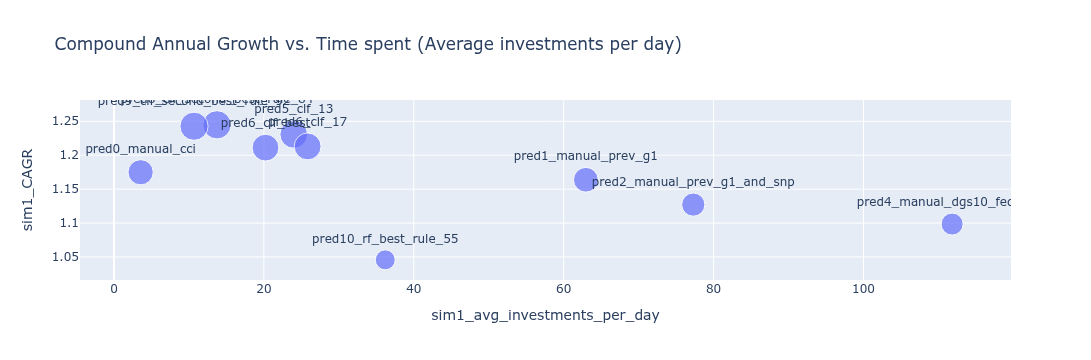

In [35]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()
     


In [36]:

# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred8_clf_second_best_rule_84'])]
     

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
8,pred8_clf_second_best_rule_84,12106,17164.574798,-1210.6,15968.674798,0.070529,1.319071,13.741203,11400.0,1.244765,2.400761


In [38]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92','pred5_clf_13'])]
     

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
5,pred5_clf_13,22281,23138.742651,-2228.1,20957.842651,0.096293,0.940615,23.983854,16200.0,1.230648,2.293694
9,pred9_clf_second_best_rule_92,9132,14191.032199,-913.2,13292.532199,0.064350,1.455599,10.680702,9600.0,1.242670,2.384639


## **Advanced Simulations**

In [46]:
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
# rank of prediction

new_df["pred8_rank"] = new_df.groupby("Date")["proba_pred8"].rank(method="first", ascending=False)

new_df["pred10_rank"] = new_df.groupby("Date")["proba_pred10"].rank(method="first", ascending=False)


In [47]:
# CHECK RANK FOR 1 DAY:
  # we have predictions for all 112 stocks
first_trading_day_2024 = new_df[new_df.Date>='2024-01-04'].Date.unique().astype(str)[0]
first_trading_day_2024
print(f'First trading day in 2024: {first_trading_day_2024}, count predictions = {len(new_df[new_df.Date==first_trading_day_2024])}')
     

First trading day in 2024: 2024-01-04, count predictions = 111


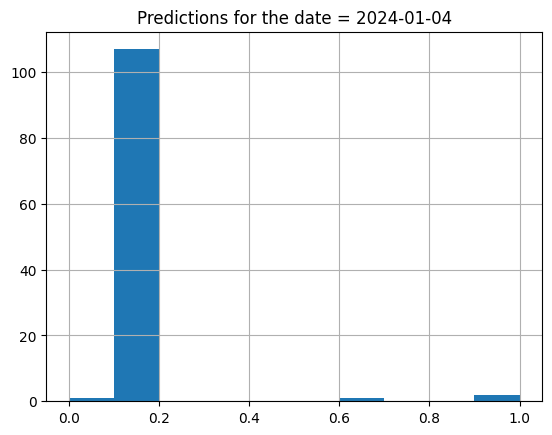

In [48]:
# Decision Tree's predictions are not very smooth - either too small or too big
new_df[new_df.Date==first_trading_day_2024].proba_pred8.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()
     

In [49]:
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker', 'Close','proba_pred8','pred8_rank']].sort_values(by='pred8_rank').head(5)
     

,Date,Ticker,Close,proba_pred8,pred8_rank
4813,2024-01-04,GLD,189.320007,1.000000,1.0
4214,2024-01-04,BND,68.802109,1.000000,2.0
6039,2024-01-04,WEC,80.596504,0.634146,3.0
6039,2024-01-04,NVDA,47.976650,0.100546,4.0
6039,2024-01-04,MSFT,363.213165,0.100546,5.0


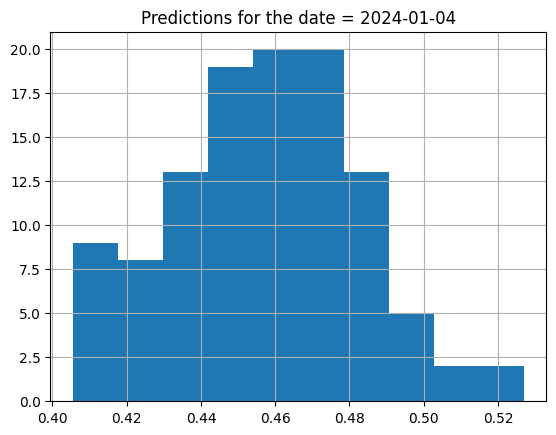

In [51]:

# Random Forest's predictions are more spreaded across the range - rank() function will work
new_df[new_df.Date==first_trading_day_2024].proba_pred10.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()
     

In [52]:
# It is quite different vs. a single Decision tree (proba_pred9 vs. proba_pred10)
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker', 'Close','proba_pred8','proba_pred10','pred10_rank']].sort_values(by='pred10_rank').head(5)
     

,Date,Ticker,Close,proba_pred8,proba_pred10,pred10_rank
4214,2024-01-04,BND,68.802109,1.000000,0.526982,1.0
6039,2024-01-04,ORCL,100.526596,0.100546,0.515527,2.0
6039,2024-01-04,T,15.623886,0.100546,0.509233,3.0
6039,2024-01-04,WMT,51.576057,0.100546,0.507405,4.0
685,2024-01-04,APP,38.119999,0.100546,0.500627,5.0


In [53]:
# Sort the DataFrame by Ticker and Date
new_df = new_df.sort_values(by=['Ticker', 'Date'])

In [54]:
new_df['growth_future_30d'].describe().T

count    615480.000000
mean          1.019894
std           0.114126
min           0.177273
25%           0.962734
50%           1.017893
75%           1.073361
max           3.993296
Name: growth_future_30d, dtype: float64

In [55]:
# take profit if growth >=20%
new_df['growth_future_30d'].quantile(0.95)

np.float64(1.1891650124605908)

In [56]:
# stop loss when -11%
new_df['growth_future_30d'].quantile(0.1)

np.float64(0.900928228163064)

In [58]:
# check a sample on the test dataset
new_df[new_df.split=='test'][['Date','High','Low','Close','Ticker','ticker_type','growth_future_30d']].sample(10)
     

,Date,High,Low,Close,Ticker,ticker_type,growth_future_30d
1620,2021-10-25,143.899994,139.501007,142.516006,SHOP,biggest_company,1.066905
72,2023-12-27,74.760002,73.410004,74.250000,ARM,biggest_company,1.551650
5887,2023-05-26,51.919998,50.930000,51.060001,BSX,biggest_company,1.027419
5767,2022-12-02,163.693768,160.395456,161.376038,CVX,biggest_company,0.979009
6003,2023-11-10,270.778710,262.612928,269.194733,SYK,biggest_company,1.093012
6217,2024-09-19,207.255901,202.786263,205.857300,JPM,biggest_company,1.060813
5758,2022-11-18,48.197941,47.726355,48.194733,WMT,biggest_company,0.960540
3990,2023-02-13,66.920082,66.736918,66.920082,BND,commodity_fund,1.005024
6026,2023-12-14,32.822744,31.377657,32.697502,BAC,biggest_company,1.025044
5912,2023-12-15,327.000000,322.589996,324.350006,ISRG,biggest_company,1.166086


In [59]:
# Define a function to get the rolling max High and min Low for the next 30 trading days

# Sort the DataFrame: Sorting by Ticker and Date ensures that we are looking at each ticker's data in chronological order.
# Rolling window calculation: We use the rolling method with a window of 5 to calculate the maximum high and minimum low over the next 5 days.
# The shift method is used to align these values correctly with the current row.

def rolling_max_min(df, window=30):
    # high/low in 30 days
    df['Max_High_Next_30'] = df['High'].rolling(window=window, min_periods=1).max().shift(-window+1)
    df['Min_Low_Next_30'] = df['Low'].rolling(window=window, min_periods=1).min().shift(-window+1)

    # low in 1 day (for lower entry)
    df['Min_Low_Next_1'] = df['Low'].rolling(window=1, min_periods=1).min().shift(-1)
    return df

In [60]:
# Apply the function to each group of Ticker
# Important!: need to drop index from groupby operation (reset_index) - so that you can merge that afterwards
result = new_df[new_df.split=='test'][['Date','High','Low','Close','Ticker']].groupby('Ticker').apply(rolling_max_min).reset_index(drop=True)
result.head(30)
     

/tmp/ipykernel_24786/1755362350.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
0,2021-10-21,146.493630,144.760842,146.336990,AAPL,166.962643,143.331623,145.514723
1,2021-10-22,147.022337,145.514723,145.563675,AAPL,166.962643,143.331623,144.516167
2,2021-10-25,146.229372,144.516167,145.514725,AAPL,166.962643,143.331623,145.876941
3,2021-10-26,147.668465,145.876941,146.180435,AAPL,168.217533,143.331623,145.367860
4,2021-10-27,146.581778,145.367860,145.720291,AAPL,172.511716,143.331623,146.572024
5,2021-10-28,149.949482,146.572024,149.362106,AAPL,173.286199,143.331623,143.331623
6,2021-10-29,146.787401,143.331623,146.650345,AAPL,176.109784,143.331623,144.692374
7,2021-11-01,146.552419,144.692374,145.827988,AAPL,178.560811,144.589823,145.524488
8,2021-11-02,148.383105,145.524488,146.865692,AAPL,178.560811,144.589823,146.669909
9,2021-11-03,148.774698,146.669909,148.304794,AAPL,178.560811,144.589823,147.472640


In [61]:
result[result.Ticker=='AAPL'].tail(10)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
955,2025-08-13,235.000000,230.429993,233.330002,AAPL,NaN,NaN,230.850006
956,2025-08-14,235.119995,230.850006,232.779999,AAPL,NaN,NaN,229.339996
957,2025-08-15,234.279999,229.339996,231.589996,AAPL,NaN,NaN,230.110001
958,2025-08-18,233.119995,230.110001,230.889999,AAPL,NaN,NaN,229.350006
959,2025-08-19,232.869995,229.350006,230.559998,AAPL,NaN,NaN,225.770004
960,2025-08-20,230.470001,225.770004,226.009995,AAPL,NaN,NaN,223.779999
961,2025-08-21,226.520004,223.779999,224.899994,AAPL,NaN,NaN,225.410004
962,2025-08-22,229.089996,225.410004,227.759995,AAPL,NaN,NaN,226.229996
963,2025-08-25,229.300003,226.229996,227.160004,AAPL,NaN,NaN,224.690002
964,2025-08-26,229.490005,224.690002,229.309998,AAPL,NaN,NaN,NaN


In [62]:
# Calculate the ratios + safe divide
result['Ratio_MaxHighNext30_to_Close'] = np.where(result['Close'] == 0, np.nan, result['Max_High_Next_30']/result['Close'])
result['Ratio_MinLowNext30_to_Close'] =  np.where(result['Close'] == 0, np.nan,  result['Min_Low_Next_30']/result['Close'])

result['Ratio_MinLowNext1_to_Close'] =  np.where(result['Close'] == 0, np.nan,  result['Min_Low_Next_1']/result['Close'])

In [63]:
result[result.Ticker=='AAPL'].head(10)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
0,2021-10-21,146.493630,144.760842,146.336990,AAPL,166.962643,143.331623,145.514723,1.140946,0.979463,0.994381
1,2021-10-22,147.022337,145.514723,145.563675,AAPL,166.962643,143.331623,144.516167,1.147008,0.984666,0.992804
2,2021-10-25,146.229372,144.516167,145.514725,AAPL,166.962643,143.331623,145.876941,1.147393,0.984997,1.002489
3,2021-10-26,147.668465,145.876941,146.180435,AAPL,168.217533,143.331623,145.367860,1.150753,0.980512,0.994441
4,2021-10-27,146.581778,145.367860,145.720291,AAPL,172.511716,143.331623,146.572024,1.183855,0.983608,1.005845
5,2021-10-28,149.949482,146.572024,149.362106,AAPL,173.286199,143.331623,143.331623,1.160175,0.959625,0.959625
6,2021-10-29,146.787401,143.331623,146.650345,AAPL,176.109784,143.331623,144.692374,1.200882,0.977370,0.986649
7,2021-11-01,146.552419,144.692374,145.827988,AAPL,178.560811,144.589823,145.524488,1.224462,0.991509,0.997919
8,2021-11-02,148.383105,145.524488,146.865692,AAPL,178.560811,144.589823,146.669909,1.215810,0.984504,0.998667
9,2021-11-03,148.774698,146.669909,148.304794,AAPL,178.560811,144.589823,147.472640,1.204012,0.974950,0.994389


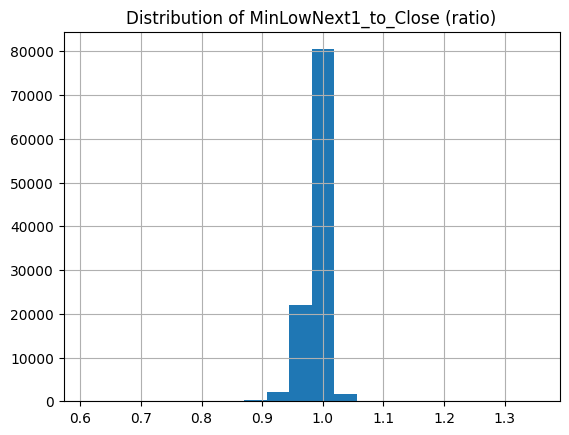

In [64]:
result.Ratio_MinLowNext1_to_Close.hist(bins=20)
plt.title(f'Distribution of MinLowNext1_to_Close (ratio)')
# Show the plot
plt.show()

In [65]:
result.Ratio_MinLowNext1_to_Close.describe().T

count    106882.000000
mean          0.988867
std           0.018208
min           0.609592
25%           0.982605
50%           0.991782
75%           0.998246
max           1.353308
Name: Ratio_MinLowNext1_to_Close, dtype: float64

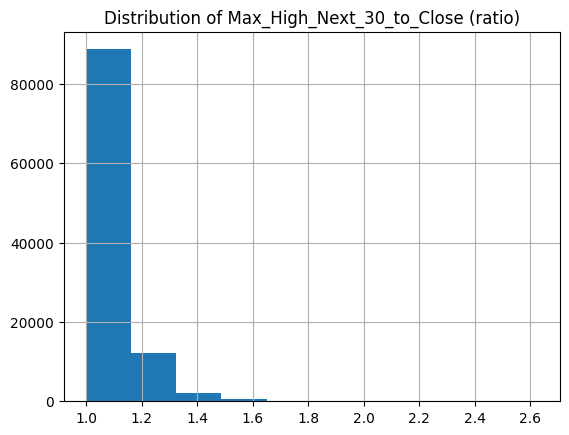

In [66]:

result.Ratio_MaxHighNext30_to_Close.hist()
plt.title(f'Distribution of Max_High_Next_30_to_Close (ratio)')
# Show the plot
plt.show()

In [67]:
result.Ratio_MaxHighNext30_to_Close.describe().T

count    103746.000000
mean          1.092269
std           0.093116
min           1.000000
25%           1.032423
50%           1.067881
75%           1.121983
max           2.624819
Name: Ratio_MaxHighNext30_to_Close, dtype: float64

In [68]:
result[result.Ratio_MaxHighNext30_to_Close>=1.3].sample(5)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
9411,2024-09-12,106.449997,97.349998,105.610001,APP,165.380005,97.349998,105.940002,1.565950,0.921788,1.003125
67936,2023-10-27,112.769997,107.669998,108.279999,PDD,147.649994,97.940002,104.000000,1.363594,0.904507,0.960473
5366,2023-12-15,140.889999,137.250000,139.149994,AMD,184.919998,133.740005,137.649994,1.328926,0.961121,0.989220
98382,2022-02-04,65.349998,64.650002,64.910004,USO,87.839996,62.849998,64.470001,1.353258,0.968264,0.993221
35534,2025-06-16,492.315695,479.791148,487.667725,GEV,655.650024,478.831577,481.390462,1.344461,0.981881,0.987128


In [69]:
# ~1.8% cases TAKE PROFIT (30%)
len(result[result.Ratio_MaxHighNext30_to_Close>=1.3])/len(result)

0.0319737555376937

<Axes: >

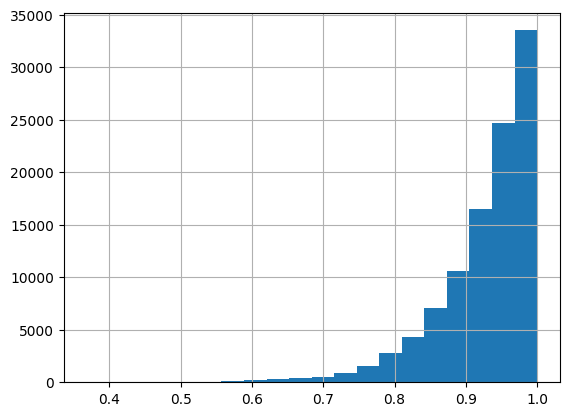

In [70]:
# High intra-day volatility, especially on earlier days after the IPO
result.Ratio_MinLowNext30_to_Close.hist(bins=20)

In [71]:
result.Ratio_MinLowNext30_to_Close.describe().T

count    103746.000000
mean          0.925743
std           0.069022
min           0.367247
25%           0.897050
50%           0.946250
75%           0.975696
max           1.000000
Name: Ratio_MinLowNext30_to_Close, dtype: float64

In [72]:
result[result.Ratio_MinLowNext30_to_Close<=0.8].sample(5)

,Date,High,Low,Close,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
75353,2022-08-15,101.694563,99.541282,101.367722,REMX,101.694563,80.546249,98.531928,1.003224,0.794595,0.972025
60390,2024-07-10,10.823783,10.765901,10.794842,MUFG,11.306128,8.441008,10.698375,1.047364,0.781948,0.991064
15079,2022-04-06,103.963116,100.781639,102.263161,BABA,103.963116,74.085710,97.448214,1.016623,0.724461,0.952916
27383,2025-02-26,198.405011,194.229741,195.611557,COF,201.059296,142.376813,195.104535,1.027850,0.727855,0.997408
9015,2023-02-14,16.219999,15.170000,15.970000,APP,17.014999,11.690000,15.790000,1.065435,0.731997,0.988729


In [73]:
# ~0.8% STOP LOSS
len(result[result.Ratio_MinLowNext30_to_Close<=0.8])/len(result)

0.055816213993308036

In [74]:
# Merge the results back with the original dataframe
new_df = new_df.merge(result[['Date', 'Ticker', 'Max_High_Next_30', 'Min_Low_Next_30','Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']], on=['Date', 'Ticker'])
     

In [75]:
new_df.sample(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,sim1_gross_rev_pred11,sim1_fees_pred11,sim1_net_rev_pred11,pred10_rank,pred8_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
75208,109.471375,111.115175,108.625445,110.548019,149100.0,0.0,0.0,commodity_fund,REMX,2022,...,-0.0,0.0,0.0,70.0,109.0,111.115175,90.745499,1.005130,0.820870,0.970000
64361,134.158324,134.378290,130.398937,131.978683,237951100.0,0.0,0.0,biggest_company,NVDA,2024,...,-0.0,0.0,0.0,15.0,4.0,153.105279,116.231243,1.160076,0.880682,0.961061
20398,68.692279,68.739688,68.578485,68.720726,7603100.0,0.0,0.0,commodity_fund,BND,2024,...,-0.0,0.0,0.0,3.0,1.0,68.986269,66.928429,1.003864,0.973919,1.000690
96529,39.255547,39.389617,39.130416,39.166168,3811500.0,0.0,0.0,biggest_company,UL,2022,...,0.0,0.0,0.0,15.0,98.0,43.349133,38.576249,1.106800,0.984938,0.997261
80138,57.527586,58.214711,57.069503,58.081104,9045900.0,0.0,0.0,biggest_company,SCHW,2022,...,0.0,0.0,0.0,72.0,94.0,67.061436,56.869096,1.154617,0.979132,0.984555


In [76]:
from dataclasses import dataclass

@dataclass
class SimulationParams:
    initial_capital: float
    threshold: float
    fees: float
    top_k: int
    portfolio_optimization: bool
    stop_loss: float
    take_profit: float
    lower_entry: float
     

# Example of initializing with some values
sim_params = SimulationParams(
    initial_capital=10000,        # initial capital = $10k
    threshold=0.55,               # select all binary predictions with probability>=0.55
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -20% from Close
    take_profit=1.3,              # automatic sell (with profit) if price (any of next 30 days) is higher than +30% from Close
    lower_entry= 0.995                # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

print(sim_params)
     

SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.995)


In [77]:
# sorted array of dates for Simulation
DATES = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
print(f' Min date {DATES.min()}, max date {DATES.max()}')
     

 Min date 2021-10-21 00:00:00, max date 2025-08-26 00:00:00


In [78]:
date = DATES[0]
date

Timestamp('2021-10-21 00:00:00')

In [79]:
# 1. get TOP_K predictions from pred10_rf_best_rule_50, that are higher than THE THRESHOLD
if sim_params.top_k is None:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred10 > sim_params.threshold)]
else:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred10 > sim_params.threshold)&(new_df.pred10_rank<=sim_params.top_k)]
     

In [83]:
one_day_predictions_df[['Date','Ticker',to_predict,'growth_future_30d','proba_pred10','pred10_rank']]

,Date,Ticker,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank
2895,2021-10-21,ACN,1,1.041196,0.590563,5.0
3860,2021-10-21,ADBE,0,0.965349,0.614241,1.0
10139,2021-10-21,ASML,0,0.979633,0.608530,2.0
27509,2021-10-21,COST,1,1.110126,0.603425,3.0
31369,2021-10-21,DHR,1,1.007080,0.576013,10.0
44269,2021-10-21,INTU,1,1.120360,0.595686,4.0
49094,2021-10-21,LIN,1,1.033605,0.590321,6.0
54884,2021-10-21,META,0,0.897508,0.577236,9.0
58744,2021-10-21,MSFT,1,1.041321,0.584453,8.0
97344,2021-10-21,UNH,1,1.019231,0.586205,7.0


In [84]:
# 2. Get non-normalized weights: probability-threshold + 0.01
one_day_predictions_df['weight'] = one_day_predictions_df.proba_pred10 - sim_params.threshold +0.01

In [85]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_30d','proba_pred10','pred10_rank','weight']]
     

,Date,Ticker,Close,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank,weight
2895,2021-10-21,ACN,327.089417,1,1.041196,0.590563,5.0,0.050563
3860,2021-10-21,ADBE,638.659973,0,0.965349,0.614241,1.0,0.074241
10139,2021-10-21,ASML,767.861450,0,0.979633,0.608530,2.0,0.068530
27509,2021-10-21,COST,454.896576,1,1.110126,0.603425,3.0,0.063425
31369,2021-10-21,DHR,271.005463,1,1.007080,0.576013,10.0,0.036013
44269,2021-10-21,INTU,564.597046,1,1.120360,0.595686,4.0,0.055686
49094,2021-10-21,LIN,295.828094,1,1.033605,0.590321,6.0,0.050321
54884,2021-10-21,META,340.014679,0,0.897508,0.577236,9.0,0.037236
58744,2021-10-21,MSFT,300.698700,1,1.041321,0.584453,8.0,0.044453
97344,2021-10-21,UNH,417.441650,1,1.019231,0.586205,7.0,0.046205


In [86]:
# 3. Get normalized weights
one_day_predictions_df['weight_norm'] = one_day_predictions_df['weight']/one_day_predictions_df['weight'].sum()
     

In [87]:
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_30d','proba_pred10','pred10_rank','weight','weight_norm']]
     

,Date,Ticker,Close,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank,weight,weight_norm
2895,2021-10-21,ACN,327.089417,1,1.041196,0.590563,5.0,0.050563,0.096004
3860,2021-10-21,ADBE,638.659973,0,0.965349,0.614241,1.0,0.074241,0.140962
10139,2021-10-21,ASML,767.861450,0,0.979633,0.608530,2.0,0.068530,0.130119
27509,2021-10-21,COST,454.896576,1,1.110126,0.603425,3.0,0.063425,0.120426
31369,2021-10-21,DHR,271.005463,1,1.007080,0.576013,10.0,0.036013,0.068377
44269,2021-10-21,INTU,564.597046,1,1.120360,0.595686,4.0,0.055686,0.105732
49094,2021-10-21,LIN,295.828094,1,1.033605,0.590321,6.0,0.050321,0.095545
54884,2021-10-21,META,340.014679,0,0.897508,0.577236,9.0,0.037236,0.070701
58744,2021-10-21,MSFT,300.698700,1,1.041321,0.584453,8.0,0.044453,0.084404
97344,2021-10-21,UNH,417.441650,1,1.019231,0.586205,7.0,0.046205,0.087730


In [88]:
# 4. Capital: either 1/30 of initial (assuming you trade every day), or everything that you can sell from 30 days ago
one_day_predictions_df['investment'] = one_day_predictions_df['weight_norm'] * sim_params.initial_capital /30
     

In [89]:
# See the allocation of an 'investment' at a price = 'Adj.Close' * sim_params.lower_entry (e.g. 0.995 - try to buy cheaper)
one_day_predictions_df[['Date','Ticker','Close', to_predict,'growth_future_30d','proba_pred10','pred10_rank','weight','weight_norm', 'investment']]
     

,Date,Ticker,Close,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank,weight,weight_norm,investment
2895,2021-10-21,ACN,327.089417,1,1.041196,0.590563,5.0,0.050563,0.096004,32.001362
3860,2021-10-21,ADBE,638.659973,0,0.965349,0.614241,1.0,0.074241,0.140962,46.987393
10139,2021-10-21,ASML,767.861450,0,0.979633,0.608530,2.0,0.068530,0.130119,43.372858
27509,2021-10-21,COST,454.896576,1,1.110126,0.603425,3.0,0.063425,0.120426,40.142068
31369,2021-10-21,DHR,271.005463,1,1.007080,0.576013,10.0,0.036013,0.068377,22.792478
44269,2021-10-21,INTU,564.597046,1,1.120360,0.595686,4.0,0.055686,0.105732,35.244056
49094,2021-10-21,LIN,295.828094,1,1.033605,0.590321,6.0,0.050321,0.095545,31.848193
54884,2021-10-21,META,340.014679,0,0.897508,0.577236,9.0,0.037236,0.070701,23.567008
58744,2021-10-21,MSFT,300.698700,1,1.041321,0.584453,8.0,0.044453,0.084404,28.134646
97344,2021-10-21,UNH,417.441650,1,1.019231,0.586205,7.0,0.046205,0.087730,29.243272


In [90]:
# 5. Lower Entry: the trade is executed only is Low price for next day is lower than bet
one_day_predictions_df['lower_entry'] = (one_day_predictions_df['Ratio_MinLowNext1_to_Close']<=sim_params.lower_entry).astype(int)
     

In [91]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,pred8_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry
2895,325.845580,327.447493,324.827914,327.089417,1520200.0,0.0,0.0,biggest_company,ACN,2021,...,78.0,353.285232,324.827914,1.080088,0.993086,1.003255,0.050563,0.096004,32.001362,0
3860,632.000000,639.169983,629.000000,638.659973,1586600.0,0.0,0.0,biggest_company,ADBE,2021,...,86.0,699.539978,629.000000,1.095325,0.984875,0.993408,0.074241,0.140962,46.987393,1
10139,745.407510,767.861450,744.763985,767.861450,1083100.0,0.0,0.0,biggest_company,ASML,2021,...,27.0,859.081323,744.763985,1.118797,0.969920,1.011059,0.068530,0.130119,43.372858,0
27509,447.785668,455.296904,447.127957,454.896576,1423300.0,0.0,0.0,biggest_company,COST,2021,...,19.0,535.401508,447.127957,1.176974,0.982922,1.002808,0.063425,0.120426,40.142068,0
31369,274.284649,274.284649,263.383050,271.005463,3239729.0,0.0,0.0,biggest_company,DHR,2021,...,87.0,289.276590,246.385188,1.067420,0.909152,0.995913,0.036013,0.068377,22.792478,0
44269,556.445629,565.163270,551.857382,564.597046,729600.0,0.0,0.0,biggest_company,INTU,2021,...,63.0,699.813349,551.857382,1.239492,0.977436,1.002853,0.055686,0.105732,35.244056,0
49094,295.695072,296.103680,293.072322,295.828094,856900.0,0.0,0.0,biggest_company,LIN,2021,...,44.0,323.243329,293.072322,1.092673,0.990685,1.004947,0.050321,0.095545,31.848193,0
54884,338.423403,340.442326,335.956923,340.014679,16354400.0,0.0,0.0,biggest_company,META,2021,...,6.0,351.899443,305.523905,1.034954,0.898561,0.939248,0.037236,0.070701,23.567008,1
58744,297.224935,300.950262,296.441133,300.698700,16918100.0,0.0,0.0,biggest_company,MSFT,2021,...,2.0,338.967969,296.441133,1.127268,0.985841,0.990475,0.044453,0.084404,28.134646,1
97344,411.042415,417.649296,410.645989,417.441650,2465100.0,0.0,0.0,biggest_company,UNH,2021,...,31.0,439.829482,410.645989,1.053631,0.983721,0.995885,0.046205,0.087730,29.243272,0


In [92]:
# 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
one_day_predictions_df['stop_loss'] = (one_day_predictions_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)
     

In [93]:
# 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
one_day_predictions_df['take_profit'] = (one_day_predictions_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

In [94]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit
2895,325.845580,327.447493,324.827914,327.089417,1520200.0,0.0,0.0,biggest_company,ACN,2021,...,324.827914,1.080088,0.993086,1.003255,0.050563,0.096004,32.001362,0,0,0
3860,632.000000,639.169983,629.000000,638.659973,1586600.0,0.0,0.0,biggest_company,ADBE,2021,...,629.000000,1.095325,0.984875,0.993408,0.074241,0.140962,46.987393,1,0,0
10139,745.407510,767.861450,744.763985,767.861450,1083100.0,0.0,0.0,biggest_company,ASML,2021,...,744.763985,1.118797,0.969920,1.011059,0.068530,0.130119,43.372858,0,0,0
27509,447.785668,455.296904,447.127957,454.896576,1423300.0,0.0,0.0,biggest_company,COST,2021,...,447.127957,1.176974,0.982922,1.002808,0.063425,0.120426,40.142068,0,0,0
31369,274.284649,274.284649,263.383050,271.005463,3239729.0,0.0,0.0,biggest_company,DHR,2021,...,246.385188,1.067420,0.909152,0.995913,0.036013,0.068377,22.792478,0,0,0
44269,556.445629,565.163270,551.857382,564.597046,729600.0,0.0,0.0,biggest_company,INTU,2021,...,551.857382,1.239492,0.977436,1.002853,0.055686,0.105732,35.244056,0,0,0
49094,295.695072,296.103680,293.072322,295.828094,856900.0,0.0,0.0,biggest_company,LIN,2021,...,293.072322,1.092673,0.990685,1.004947,0.050321,0.095545,31.848193,0,0,0
54884,338.423403,340.442326,335.956923,340.014679,16354400.0,0.0,0.0,biggest_company,META,2021,...,305.523905,1.034954,0.898561,0.939248,0.037236,0.070701,23.567008,1,0,0
58744,297.224935,300.950262,296.441133,300.698700,16918100.0,0.0,0.0,biggest_company,MSFT,2021,...,296.441133,1.127268,0.985841,0.990475,0.044453,0.084404,28.134646,1,0,0
97344,411.042415,417.649296,410.645989,417.441650,2465100.0,0.0,0.0,biggest_company,UNH,2021,...,410.645989,1.053631,0.983721,0.995885,0.046205,0.087730,29.243272,0,0,0


In [95]:
# future_gross_return, depending on lower_entry, take_profit, stop_loss

import random

def get_future_gross_return(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade, investment is untouched, no fees
    return row['investment']

  # buy trade is filled for ALL next cases:
  if row['take_profit']==1 and row['stop_loss']==1:
    if random.random()>0.5: #assume take_profit event was first
      return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))
    else: #assume stop_loss event was first
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  if row['take_profit']==1: # take some good profit, pay fees
    return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))

  if row['stop_loss']==1: # fix the loss, pay fees
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  # no stop_loss and no take_profit
  if pd.isna(row['growth_future_30d']):
    return row['investment'] # no information on growth in 30 days --> return the same investment in 5 days
  else:
    return row['investment']*(row['growth_future_30d']+(1-sim_params.lower_entry))
     

In [96]:
# fees, depending on lower_entry, take_profit, stop_loss

def get_fees(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade ==> no fees
    return 0

  # pay fees in all other cases
  return -row['investment']*sim_params.fees

In [97]:
# 8. calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
one_day_predictions_df['future_gross_return'] = one_day_predictions_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
one_day_predictions_df['fees'] =  one_day_predictions_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
one_day_predictions_df['future_net_return'] = one_day_predictions_df['future_gross_return'] + one_day_predictions_df['fees']

# OLD code when no stop_loss, take_profit, and if order executed
# one_day_predictions_df['investment'] * one_day_predictions_df['growth_future_5d']
# one_day_predictions_df['fees'] =   - one_day_predictions_df['investment'] * sim_params.fees


In [98]:
# result
one_day_predictions_df
     

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker_type,Ticker,Year,...,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
2895,325.845580,327.447493,324.827914,327.089417,1520200.0,0.0,0.0,biggest_company,ACN,2021,...,1.003255,0.050563,0.096004,32.001362,0,0,0,32.001362,0.000000,32.001362
3860,632.000000,639.169983,629.000000,638.659973,1586600.0,0.0,0.0,biggest_company,ADBE,2021,...,0.993408,0.074241,0.140962,46.987393,1,0,0,45.594189,-0.093975,45.500214
10139,745.407510,767.861450,744.763985,767.861450,1083100.0,0.0,0.0,biggest_company,ASML,2021,...,1.011059,0.068530,0.130119,43.372858,0,0,0,43.372858,0.000000,43.372858
27509,447.785668,455.296904,447.127957,454.896576,1423300.0,0.0,0.0,biggest_company,COST,2021,...,1.002808,0.063425,0.120426,40.142068,0,0,0,40.142068,0.000000,40.142068
31369,274.284649,274.284649,263.383050,271.005463,3239729.0,0.0,0.0,biggest_company,DHR,2021,...,0.995913,0.036013,0.068377,22.792478,0,0,0,22.792478,0.000000,22.792478
44269,556.445629,565.163270,551.857382,564.597046,729600.0,0.0,0.0,biggest_company,INTU,2021,...,1.002853,0.055686,0.105732,35.244056,0,0,0,35.244056,0.000000,35.244056
49094,295.695072,296.103680,293.072322,295.828094,856900.0,0.0,0.0,biggest_company,LIN,2021,...,1.004947,0.050321,0.095545,31.848193,0,0,0,31.848193,0.000000,31.848193
54884,338.423403,340.442326,335.956923,340.014679,16354400.0,0.0,0.0,biggest_company,META,2021,...,0.939248,0.037236,0.070701,23.567008,1,0,0,21.269411,-0.047134,21.222277
58744,297.224935,300.950262,296.441133,300.698700,16918100.0,0.0,0.0,biggest_company,MSFT,2021,...,0.990475,0.044453,0.084404,28.134646,1,0,0,29.437871,-0.056269,29.381602
97344,411.042415,417.649296,410.645989,417.441650,2465100.0,0.0,0.0,biggest_company,UNH,2021,...,0.995885,0.046205,0.087730,29.243272,0,0,0,29.243272,0.000000,29.243272


In [99]:
# Simulation Parameters
sim_params = SimulationParams(
    initial_capital=10000,                 # initial capital = $10k
    threshold=0.55,                        # select all binary predictions with probability>=0.55
    fees=0.002,                            # trading fees = 0.2% (buy+sell)
    top_k=10,                              # select top_k predictions
    portfolio_optimization=False,          # no portfolio optimizaiton
    stop_loss=0.8,                         # automatic sell (with loss) if price (any of next 30 trading days) is lower than -20% from Close
    take_profit=1.3,                       # automatic sell (with profit) if price (any of next 30 trading days) is higher than +30% from Close
    lower_entry= 0.995                     # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

In [116]:
def one_date_simulation(date:str, invest_sum:float, df:pd.DataFrame, sim_params:SimulationParams, predictor:str='proba_pred8'):

  rank_column = predictor.split('_')[1]+'_rank' # e.g. 'proba_pred8' --> 'pred8_rank'
  # 1. get TOP_K (or ALL) predictions from the predictor (pred14_rf_best_rule_53 by default), that are higher than THE THRESHOLD
  if sim_params.top_k is None:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)]
  else:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)&(df[rank_column]<=sim_params.top_k)]

  FIELDS = ['Close', 'Ticker', 'Date', predictor, rank_column, 'growth_future_30d', 'Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']
  result_df = one_day_predictions_df[FIELDS].copy()

  # 2. Get non-normalized weights: probability-threshold + 0.01
  result_df['weight'] = result_df[predictor] - sim_params.threshold +0.01

  # 3. Get normalized weights
  result_df['weight_norm'] = result_df['weight']/result_df['weight'].sum()

  # 4. Make bets to allocate 'invest_sum' across all suitable predictions
  result_df['investment'] = result_df['weight_norm'] * invest_sum

  # 5. Lower Entry: the trade is executed only is Low price for next day is lower than the bet (Adj_Close_today * sim_params.lower_entry)
    # [ONLY TRADES with lower_entry==1 are filled by the exchange]
  result_df['lower_entry'] = (result_df['Ratio_MinLowNext1_to_Close'] <= sim_params.lower_entry).astype(int)

  # 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
  result_df['stop_loss'] = (result_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

  # 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
  result_df['take_profit'] = (result_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

  # 8. Calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
  result_df['future_gross_return'] = result_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
  result_df['fees'] =  result_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
  result_df['future_net_return'] = result_df['future_gross_return'] + result_df['fees']

  return result_df

In [117]:
predictor = 'proba_pred8'
rank = predictor.split('_')[1]+'_rank'
print(rank)

pred8_rank


In [118]:
r = one_date_simulation(date='2021-09-14', invest_sum=sim_params.initial_capital/30, df=new_df, sim_params=sim_params, predictor='proba_pred8')
     

In [119]:
# initial investment
r.investment.sum()
     

np.float64(0.0)

In [120]:
# result in 30 days (returns+fees)
r.future_net_return.sum()

np.float64(0.0)

In [121]:
all_dates = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
all_dates

<DatetimeArray>
['2021-10-21 00:00:00', '2021-10-22 00:00:00', '2021-10-25 00:00:00',
 '2021-10-26 00:00:00', '2021-10-27 00:00:00', '2021-10-28 00:00:00',
 '2021-10-29 00:00:00', '2021-11-01 00:00:00', '2021-11-02 00:00:00',
 '2021-11-03 00:00:00',
 ...
 '2025-08-13 00:00:00', '2025-08-14 00:00:00', '2025-08-15 00:00:00',
 '2025-08-18 00:00:00', '2025-08-19 00:00:00', '2025-08-20 00:00:00',
 '2025-08-21 00:00:00', '2025-08-22 00:00:00', '2025-08-25 00:00:00',
 '2025-08-26 00:00:00']
Length: 965, dtype: datetime64[ns]

In [122]:
# simulate for all dates but last 5
all_dates[0:-5]
     

<DatetimeArray>
['2021-10-21 00:00:00', '2021-10-22 00:00:00', '2021-10-25 00:00:00',
 '2021-10-26 00:00:00', '2021-10-27 00:00:00', '2021-10-28 00:00:00',
 '2021-10-29 00:00:00', '2021-11-01 00:00:00', '2021-11-02 00:00:00',
 '2021-11-03 00:00:00',
 ...
 '2025-08-06 00:00:00', '2025-08-07 00:00:00', '2025-08-08 00:00:00',
 '2025-08-11 00:00:00', '2025-08-12 00:00:00', '2025-08-13 00:00:00',
 '2025-08-14 00:00:00', '2025-08-15 00:00:00', '2025-08-18 00:00:00',
 '2025-08-19 00:00:00']
Length: 960, dtype: datetime64[ns]

In [123]:
# these last days we only "sell" the positions
all_dates[-5:]

<DatetimeArray>
['2025-08-20 00:00:00', '2025-08-21 00:00:00', '2025-08-22 00:00:00',
 '2025-08-25 00:00:00', '2025-08-26 00:00:00']
Length: 5, dtype: datetime64[ns]

In [124]:
capital= 5 * [sim_params.initial_capital/5]
capital[-5]
     

2000.0

In [125]:
def simulate(df:pd.DataFrame, sim_params:SimulationParams):

  simulation_df = None

  # all dates for simulation
  all_dates = df[df.split=='test'].sort_values(by='Date').Date.unique()

  # arrays of dates and capital available (capital for the first 5 days)
  dates = []
  capital= 30 * [sim_params.initial_capital/30]  # first 30 periods trade with 1/30 of the initial_capital. e.g. [333,...,333] = 10k in total

  for current_date in all_dates[0:-30]:  #growth_future_30d is not defined for the last 30 days : ALL, but last 30 dates

    current_invest_sum = capital[-30]    # take the value or everything that you can sell from 30 days ago

    one_day_simulation_results = one_date_simulation(date = current_date,  # one day simulation result
                                    invest_sum = current_invest_sum,
                                    df = df,
                                    sim_params=sim_params,
                                    predictor='proba_pred10')

    # add capital available in 30 days
    if len(one_day_simulation_results)==0:  #no predictions -> no trades
      capital.append(current_invest_sum)
    else:
      capital.append(one_day_simulation_results.future_net_return.sum())
    dates.append(current_date)

    if simulation_df is None:
      simulation_df = one_day_simulation_results
    else:
      simulation_df = pd.concat([simulation_df, one_day_simulation_results], ignore_index=True)

  # add last 5 days to make the count of data points equal for dates/capital arrays
  dates.extend(all_dates[-30:])
  capital_df = pd.DataFrame({'capital':capital}, index=pd.to_datetime(dates))

  # results:
  print(f'============================================================================================')
  print(f'SIMULATION STARTED')
  print(f'Simulations params: {sim_params}')
  print(f' Count bids {len(simulation_df)} in total, avg.bids per day {len(simulation_df)/simulation_df.Date.nunique()},  filled bids {len(simulation_df[simulation_df.lower_entry==1])}, fill bids percent = {len(simulation_df[simulation_df.lower_entry==1])/len(simulation_df)}')
  stop_loss_filter = (simulation_df.lower_entry==1)&(simulation_df.stop_loss==1)
  print(f'  Stop loss events: count = {len(simulation_df[stop_loss_filter])}, net loss = {simulation_df[stop_loss_filter].future_net_return.sum()-simulation_df[stop_loss_filter].investment.sum()} ')
  take_profit_filter = (simulation_df.lower_entry==1)&(simulation_df.take_profit==1)
  print(f'  Take profit events: count = {len(simulation_df[take_profit_filter])}, net profit = {simulation_df[take_profit_filter].future_net_return.sum()-simulation_df[take_profit_filter].investment.sum()} ')
  print(f'  Start capital = {sim_params.initial_capital}, Resulting capital: {capital_df[-30:].capital.sum()} ')
  print(f'  CAGR in 4 years: {np.round((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4),3)} or {np.round(((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4)-1)*100.0,2)} % of avg. growth per year')
  print(f'============================================================================================')
  return simulation_df,capital_df  

In [126]:
# One initial simulation
sim_params = SimulationParams(
    initial_capital = 10000,        # initial capital = $10k
    threshold = 0.55,               # select all binary predictions with probability>=0.55
    fees = 0.002,                   # trading fees = 0.2% (buy+sell)
    top_k = 5,                      # select top_k=5 predictions
    portfolio_optimization = False, # no portfolio optimization
    stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -20% from Adj.Close
    take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +30% from Adj.Close
    lower_entry = 0.99               # buy next day with the price = [Close] * 0.99 (try to buy cheaper)
)

res, capital = simulate(new_df, sim_params)
     

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
 Count bids 2365 in total, avg.bids per day 3.9814814814814814,  filled bids 1030, fill bids percent = 0.4355179704016913
  Stop loss events: count = 104, net loss = -1338.2624052699684 
  Take profit events: count = 50, net profit = 1083.1363039799862 
  Start capital = 10000, Resulting capital: 11173.655953645697 
  CAGR in 4 years: 1.028 or 2.81 % of avg. growth per year


In [115]:
# BEST PREVIOUS CAGR is 7.8%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
# iterate over lower_entry
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.97)
 Count bids 2365 in total, avg.bids per day 3.9814814814814814,  filled bids 267, fill bids percent = 0.11289640591966173
  Stop loss events: count = 45, net loss = -525.3760321225504 
  Take profit events: count = 20, net profit = 522.283507444316 
  Start capital = 10000, Resulting capital: 10658.692861163201 
  CAGR in 4 years: 1.016 or 1.61 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.98)
 Count bids 2365 in total, avg.bids per day 3.9814814814814814,  filled bids 516, fill bids percent = 0.21818181818181817
  Stop loss events: count = 68, net loss = -872.9003496755718 
  Take profit events: count = 29, net profit = 659

In [ ]:

# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99 ==> lower_entry=1.0)

# iterate over take profit   ==> new best take_profit=1.5
for take_profit in [1.2,1.25,1.3,1.35,1.4,1.45,1.5]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -5% from Adj.Close
      take_profit = take_profit,        # automatic sell (with profit) if price (any of next 30 days) is higher than +20% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)
     